In [2]:
!pip install kaggle

from google.colab import files
files.upload()   # 👉 yahan apna kaggle.json upload karo


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"farwamajid","key":"9f4040d72adaed96b2798eef4ccbb76d"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle\ \(1\).json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
# Download Covertype dataset from UCI repository
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
!gunzip covtype.data.gz


--2025-09-20 16:55:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘covtype.data.gz’

covtype.data.gz         [  <=>               ]  10.72M  32.5MB/s    in 0.3s    

2025-09-20 16:55:16 (32.5 MB/s) - ‘covtype.data.gz’ saved [11240707]



Shape of dataset: (581012, 54) (581012,)
Unique classes in y: [1 2 3 4 5 6 7]

🌲 Random Forest Results:
Accuracy: 0.9533316695782381
              precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.92      0.86      0.89       549
           5       0.95      0.77      0.85      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:12:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



⚡ XGBoost Results:
Accuracy: 0.8696074972246843
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     42368
           1       0.87      0.90      0.88     56661
           2       0.89      0.91      0.90      7151
           3       0.88      0.86      0.87       549
           4       0.89      0.61      0.72      1899
           5       0.85      0.80      0.82      3473
           6       0.95      0.91      0.93      4102

    accuracy                           0.87    116203
   macro avg       0.88      0.83      0.85    116203
weighted avg       0.87      0.87      0.87    116203



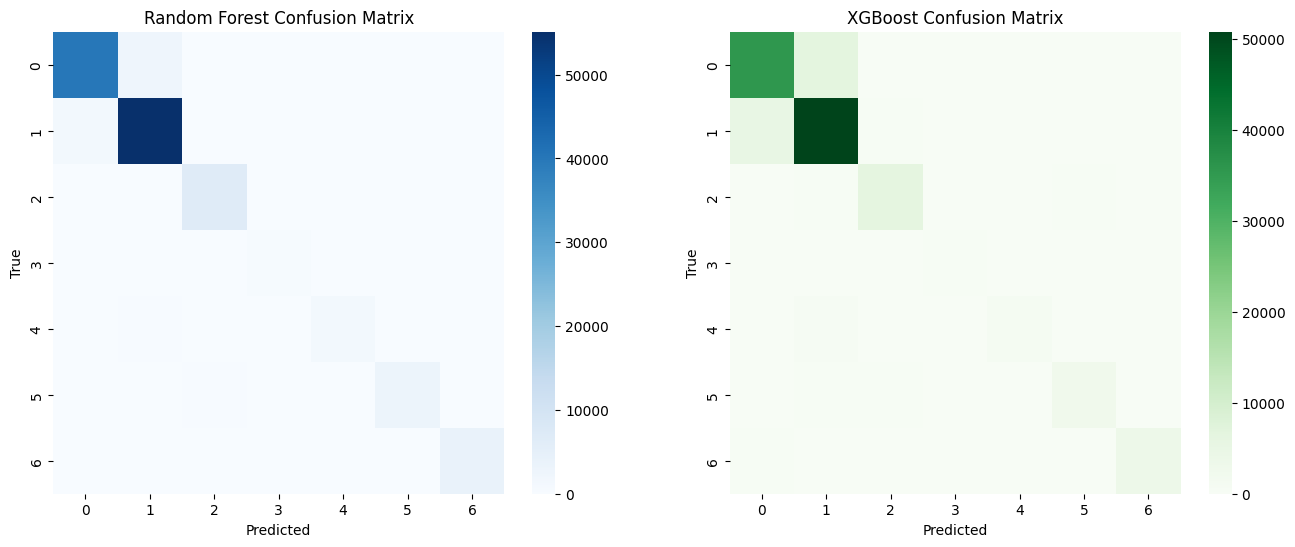

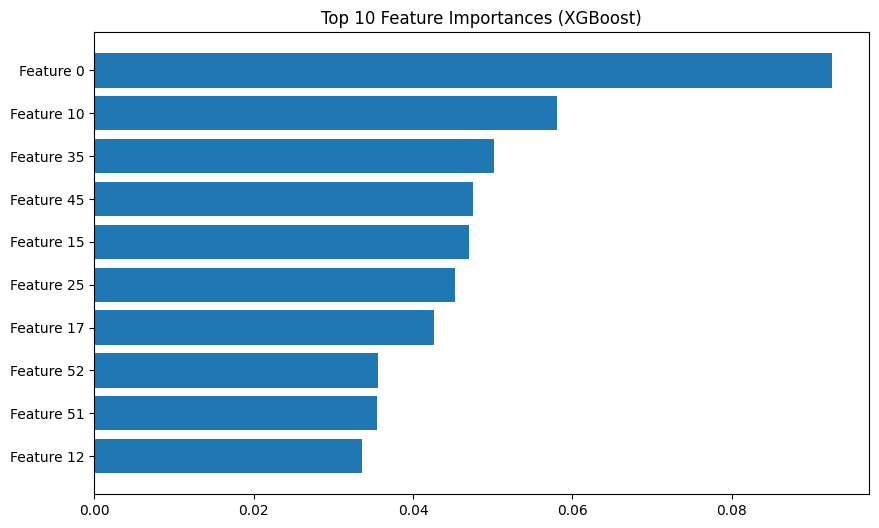

In [7]:
# 📌 Forest Cover Type Classification - RandomForest vs XGBoost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --------------------------
# Step 1: Load Dataset
# --------------------------
df = pd.read_csv("covtype.data", header=None)

# According to UCI dataset description → last column is target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print("Shape of dataset:", X.shape, y.shape)
print("Unique classes in y:", np.unique(y))

# --------------------------
# Step 2: Train/Test Split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------
# Step 3: Encode Labels (0-based for XGBoost)
# --------------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --------------------------
# Step 4: Random Forest
# --------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n🌲 Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# --------------------------
# Step 5: XGBoost
# --------------------------
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
    objective="multi:softmax",
    num_class=len(le.classes_)
)

xgb.fit(X_train, y_train_enc)
y_pred_xgb = xgb.predict(X_test)

print("\n⚡ XGBoost Results:")
print("Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))
print(classification_report(y_test_enc, y_pred_xgb))

# --------------------------
# Step 6: Confusion Matrix
# --------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=False, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Random Forest Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(confusion_matrix(y_test_enc, y_pred_xgb), annot=False, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("XGBoost Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.show()

# --------------------------
# Step 7: Feature Importance (XGBoost)
# --------------------------
xgb_importances = xgb.feature_importances_
indices = np.argsort(xgb_importances)[-10:]  # top 10 features

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), xgb_importances[indices], align='center')
plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()
